<a href="https://colab.research.google.com/github/jrgosalvez/data255_DL/blob/main/HW5-GAN_and_LSGAN/Jorge_Gosalvez_255_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SJSU MSDS 255 DL, Spring 2024
Homework 05: GAN

Git: https://github.com/jrgosalvez/data255_DL

# Part 1 -  GAN

### Step 1. Load Fashion MNIST & Replace Dataset in Demo

In [ ]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import warnings
warnings.filterwarnings("ignore")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Fashion MNIST Dataset
transform = transforms.Compose([transforms.ToTensor()])

#transform = transforms.Compose([transforms.ToTensor(),
#  transforms.Normalize((0.5,), (0.5,))
#])

train_dataset = datasets.FashionMNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset  = datasets.FashionMNIST(root='./mnist_data/', train=False, transform=transform, download=False)

In [ ]:
img, label = train_dataset[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[0.0000, 0.0000, 0.0000, 0.7569, 0.8941],
         [0.0118, 0.0000, 0.0471, 0.8588, 0.8627],
         [0.0235, 0.0000, 0.3882, 0.9569, 0.8706],
         [0.0000, 0.0000, 0.2157, 0.9255, 0.8941],
         [0.0000, 0.0000, 0.9294, 0.8863, 0.8510]]])


(tensor(0.), tensor(1.))

In [ ]:
def denorm(x):
    out = (x+1) / 2
    return out.clamp(0,1)

Label: 9


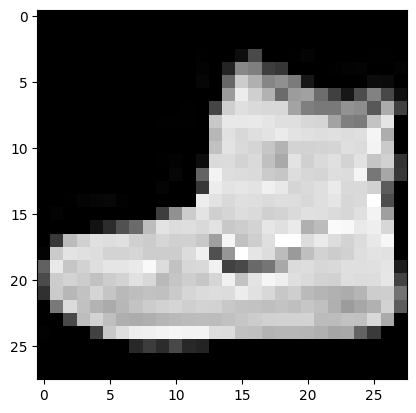

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

#### Download in batches

In [ ]:
batch_size = 100

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

first batch
torch.Size([100, 1, 28, 28])
tensor([6, 6, 5, 0, 0, 0, 8, 9, 5, 4, 5, 7, 5, 7, 7, 9, 1, 6, 9, 4, 9, 2, 0, 1,
        5, 6, 8, 7, 0, 6, 5, 9, 9, 6, 0, 9, 3, 7, 0, 2, 1, 6, 2, 3, 9, 9, 7, 9,
        0, 3, 6, 1, 0, 4, 4, 9, 5, 8, 1, 2, 9, 8, 5, 5, 0, 3, 5, 2, 1, 6, 2, 6,
        3, 0, 7, 8, 1, 3, 1, 6, 2, 1, 4, 0, 7, 6, 7, 6, 3, 4, 7, 8, 9, 4, 3, 2,
        8, 2, 7, 2])


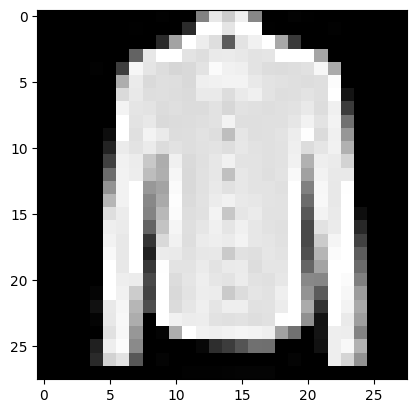

In [ ]:
for img_batch, label_batch in train_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

### Step 2. Train GAN to produce images

In [ ]:
image_size  = 784
step_size   = 512
hidden_size = 256
latent_size = 100

In [ ]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [ ]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, step_size),
    nn.ReLU(),
    nn.Linear(step_size, image_size),
    nn.Tanh())

#### Instantiate the generator and generage random fake images

In [ ]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

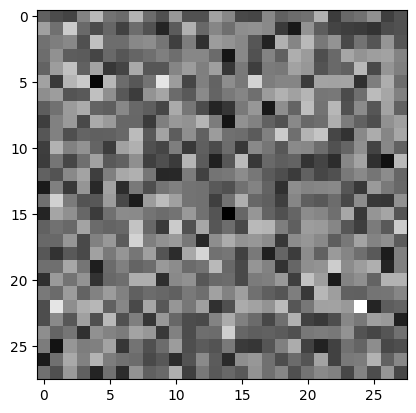

In [ ]:
plt.imshow(gen_imgs[0], cmap='gray');

#### Build the network and move generator and discriminator to the device

In [ ]:
D.to(device);

In [ ]:
G.to(device);

In [ ]:
G

Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=784, bias=True)
  (7): Tanh()
)

In [ ]:
D

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [ ]:
# loss
criterion = nn.BCELoss()

# optimizer
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [ ]:
def reset_grad():
    D_optimizer.zero_grad()
    G_optimizer.zero_grad()

def D_train(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    D_optimizer.step()

    return d_loss, real_score, fake_score

In [ ]:
def G_train():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    G_optimizer.step()
    return g_loss, fake_images

## Train the model

#### Create and save intermediate outputs from the generator for visual inspection later

In [ ]:
import os

sample_dir = 'sample_data'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

#### Batch of real training images

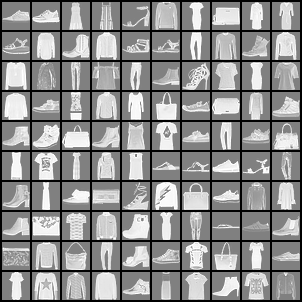

In [ ]:
from IPython.display import Image

# Save some real images
for images, _ in train_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

#### Helper function to save batch of generated images at end of ea epoch to see evolution over time

Saving fake_images-0000.png


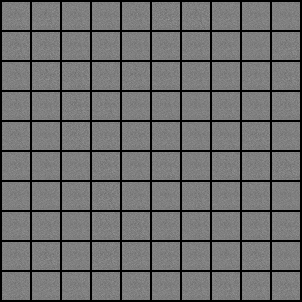

In [ ]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

#### Train Model

In [ ]:
%%time

num_epochs = 300
total_step = len(train_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = D_train(images) # discriminator ingests real and fake images
        g_loss, fake_images = G_train()                  # generator creates images

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.9021, g_loss: 1.0028, D(x): 0.76, D(G(z)): 0.45
Epoch [0/300], Step [400/600], d_loss: 0.4956, g_loss: 2.5053, D(x): 0.87, D(G(z)): 0.29
Epoch [0/300], Step [600/600], d_loss: 1.1539, g_loss: 1.9080, D(x): 0.49, D(G(z)): 0.35
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.8306, g_loss: 1.3722, D(x): 0.72, D(G(z)): 0.34
Epoch [1/300], Step [400/600], d_loss: 0.9764, g_loss: 1.5389, D(x): 0.73, D(G(z)): 0.28
Epoch [1/300], Step [600/600], d_loss: 2.6185, g_loss: 1.4281, D(x): 0.24, D(G(z)): 0.37
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.8699, g_loss: 1.0720, D(x): 0.70, D(G(z)): 0.37
Epoch [2/300], Step [400/600], d_loss: 0.8243, g_loss: 1.0500, D(x): 0.74, D(G(z)): 0.37
Epoch [2/300], Step [600/600], d_loss: 1.1099, g_loss: 1.8794, D(x): 0.66, D(G(z)): 0.24
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 2.4335, g_loss: 0.3414, D(x): 0.66, D(G(z)): 0.78
Epoch [3/300], Step [400/6

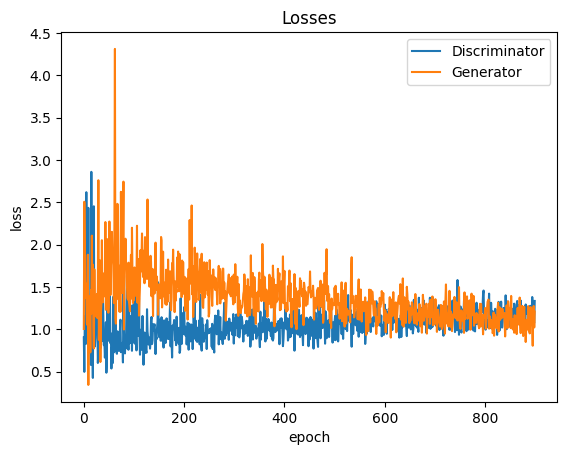

In [ ]:
import matplotlib.pyplot as plt

plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

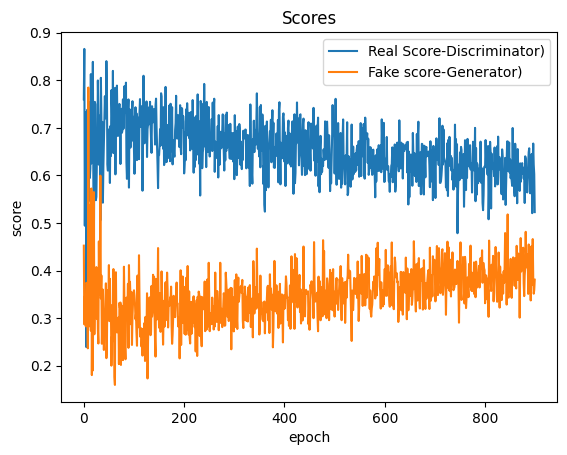

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score-Discriminator)', 'Fake score-Generator)'])
plt.title('Scores');

#### Evaluate Performance of GAN model (first 300 epochs)

In [ ]:
def evaluate_discriminator(discriminator, test_loader):
    discriminator.eval()  # Set the model to evaluation mode
    correct_real = 0
    correct_fake = 0
    total = 0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.reshape(-1, image_size).to(device)
            outputs = discriminator(images)
            predicted_labels = (outputs >= 0.5).float()  # Threshold at 0.5 for binary classification

            # Compute accuracy for real and fake images separately
            correct_real += (predicted_labels[:len(images)//2] == 1).sum().item()  # Assuming first half are real images
            correct_fake += (predicted_labels[len(images)//2:] == 0).sum().item()  # Assuming second half are fake images
            total += len(images)

    accuracy_real = 100 * correct_real / (total // 2)
    accuracy_fake = 100 * correct_fake / (total // 2)
    accuracy_total = 100 * (correct_real + correct_fake) / total

    print('Accuracy on real images: {:.2f}%'.format(accuracy_real))
    print('Accuracy on fake images: {:.2f}%'.format(accuracy_fake))
    print('Overall accuracy: {:.2f}%'.format(accuracy_total))

    return accuracy_real, accuracy_fake, accuracy_total

# Usage
GAN_real, GAN_fake, GAN_overall = evaluate_discriminator(D, test_loader)

Accuracy on real images: 59.74%
Accuracy on fake images: 40.80%
Overall accuracy: 50.27%


### Step 3. Show 3+ samples created by GAN. Share lessons learned.

#### Show fake images after 10th, 50th, 100th and 300th epochs of training

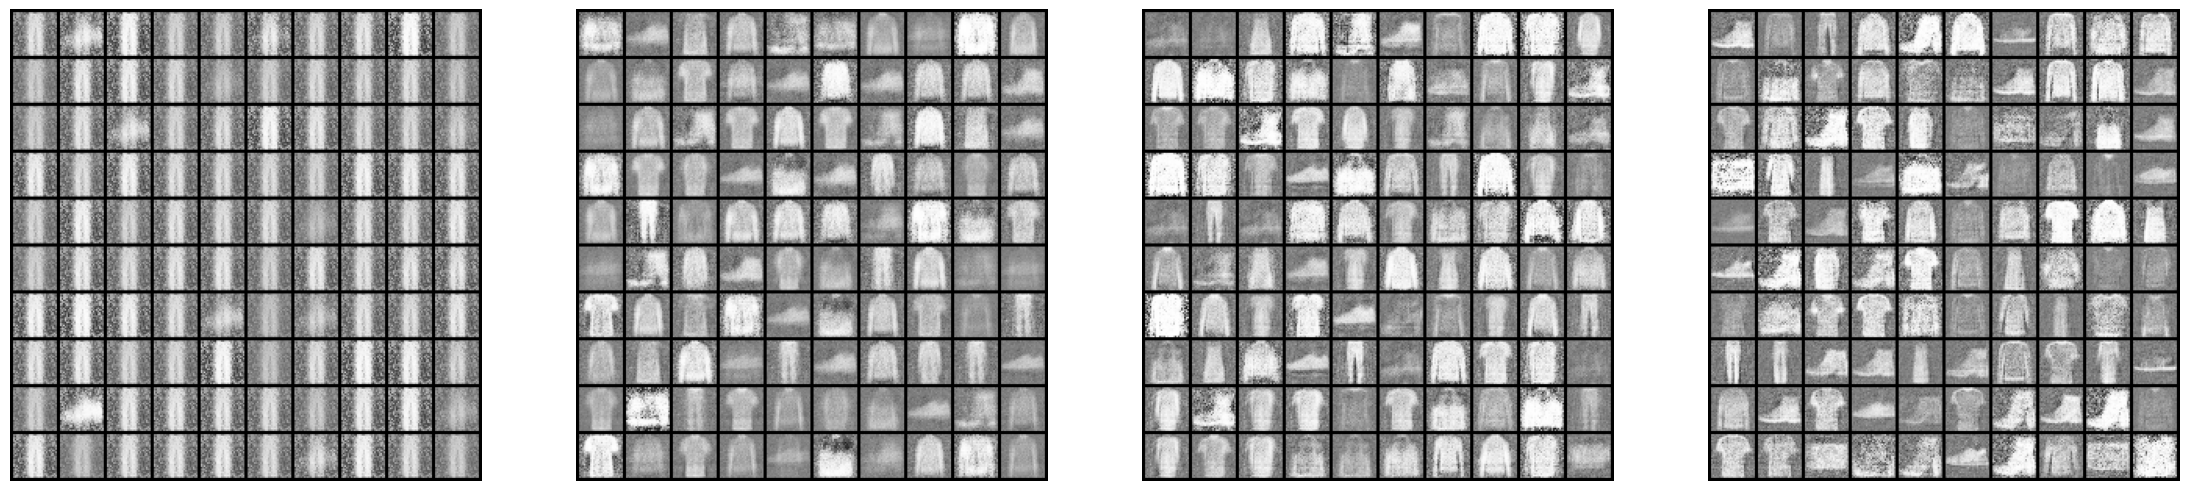

In [ ]:
import matplotlib.image as mpimg

# List of image paths
image_paths = [
    './sample_data/fake_images-0010.png',
    './sample_data/fake_images-0050.png',
    './sample_data/fake_images-0100.png',
    './sample_data/fake_images-0300.png'
]

# Plot images side by side
plt.figure(figsize=(28, 28))
for i, path in enumerate(image_paths):
    plt.subplot(1, len(image_paths), i + 1)
    img = mpimg.imread(path)
    plt.imshow(img)
    plt.axis('off')
plt.show()

- Generation of image samples called individually yields usable results.
- Generator improves with practice.
- Gets close to real images.

#### Generate a time series video. <b>NOTE:</b> Images must be resized to match the dimensions of the video frames.

In [54]:
import cv2
import os
from IPython.display import FileLink

vid_fname  = 'gans_training.mp4'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.mp4')

/content/gans_training.avi

### Step 4. Save model weights with checkpoints

In [ ]:
torch.save(G.state_dict(), 'generator_weights_checkpoints.ckpt')
torch.save(D.state_dict(), 'discriminator_weights_checkpoints.ckpt')

### Step 5. Load model

In [ ]:
# Load checkpoint models for generator and discriminator
generator_checkpoint_path     = 'generator_weights_checkpoints.ckpt'
discriminator_checkpoint_path = 'discriminator_weights_checkpoints.ckpt'

# Load weights into the models
G.load_state_dict(torch.load(generator_checkpoint_path))
D.load_state_dict(torch.load(discriminator_checkpoint_path))

<All keys matched successfully>

In [ ]:
# Set models to evaluation mode
G.eval()

Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=784, bias=True)
  (7): Tanh()
)

In [ ]:
D.eval()

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

### Step 6. Re-train GAN (100 epochs)

Saving transf_fake_images-0000.png


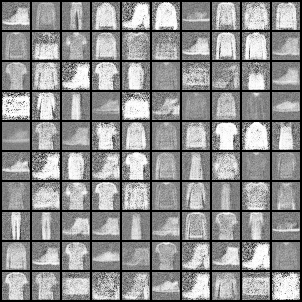

In [ ]:
def save_transf_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'transf_fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_transf_fake_images(0)
Image(os.path.join(sample_dir, 'transf_fake_images-0000.png'))

In [ ]:
%%time

num_epochs = 100
total_step = len(train_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = D_train(images) # discriminator ingests real and fake images
        g_loss, fake_images = G_train()                  # generator creates images

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_transf_fake_images(epoch+1)

Epoch [0/100], Step [200/600], d_loss: 1.3719, g_loss: 0.9268, D(x): 0.55, D(G(z)): 0.43
Epoch [0/100], Step [400/600], d_loss: 1.1726, g_loss: 1.0644, D(x): 0.61, D(G(z)): 0.40
Epoch [0/100], Step [600/600], d_loss: 1.2483, g_loss: 1.0562, D(x): 0.55, D(G(z)): 0.38
Saving transf_fake_images-0001.png
Epoch [1/100], Step [200/600], d_loss: 1.1881, g_loss: 1.0277, D(x): 0.64, D(G(z)): 0.43
Epoch [1/100], Step [400/600], d_loss: 1.0872, g_loss: 1.1648, D(x): 0.64, D(G(z)): 0.40
Epoch [1/100], Step [600/600], d_loss: 1.2000, g_loss: 1.0752, D(x): 0.59, D(G(z)): 0.37
Saving transf_fake_images-0002.png
Epoch [2/100], Step [200/600], d_loss: 1.0954, g_loss: 1.0829, D(x): 0.64, D(G(z)): 0.40
Epoch [2/100], Step [400/600], d_loss: 1.0965, g_loss: 1.1122, D(x): 0.63, D(G(z)): 0.39
Epoch [2/100], Step [600/600], d_loss: 1.1081, g_loss: 1.2404, D(x): 0.64, D(G(z)): 0.38
Saving transf_fake_images-0003.png
Epoch [3/100], Step [200/600], d_loss: 1.1688, g_loss: 1.0422, D(x): 0.62, D(G(z)): 0.41
Epoch

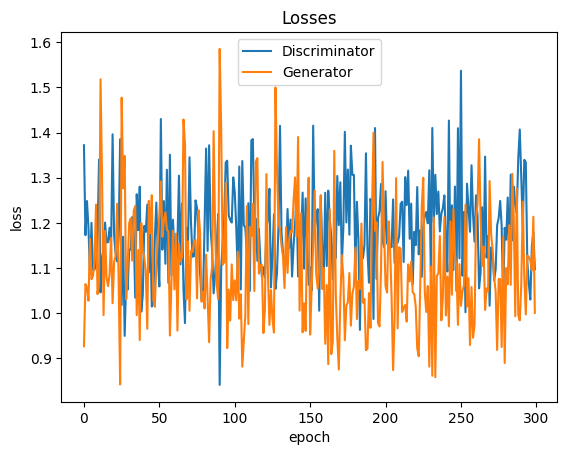

In [ ]:
import matplotlib.pyplot as plt

plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

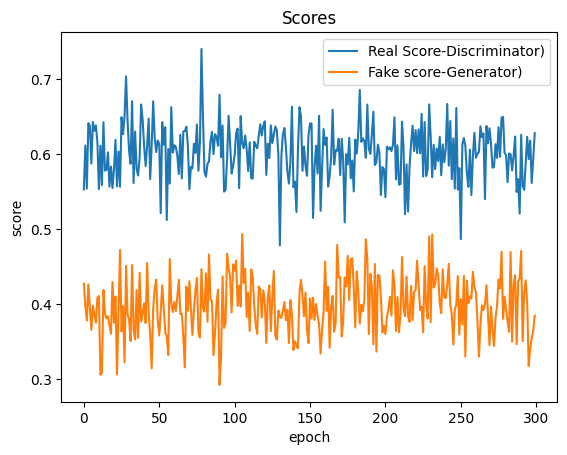

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score-Discriminator)', 'Fake score-Generator)'])
plt.title('Scores');

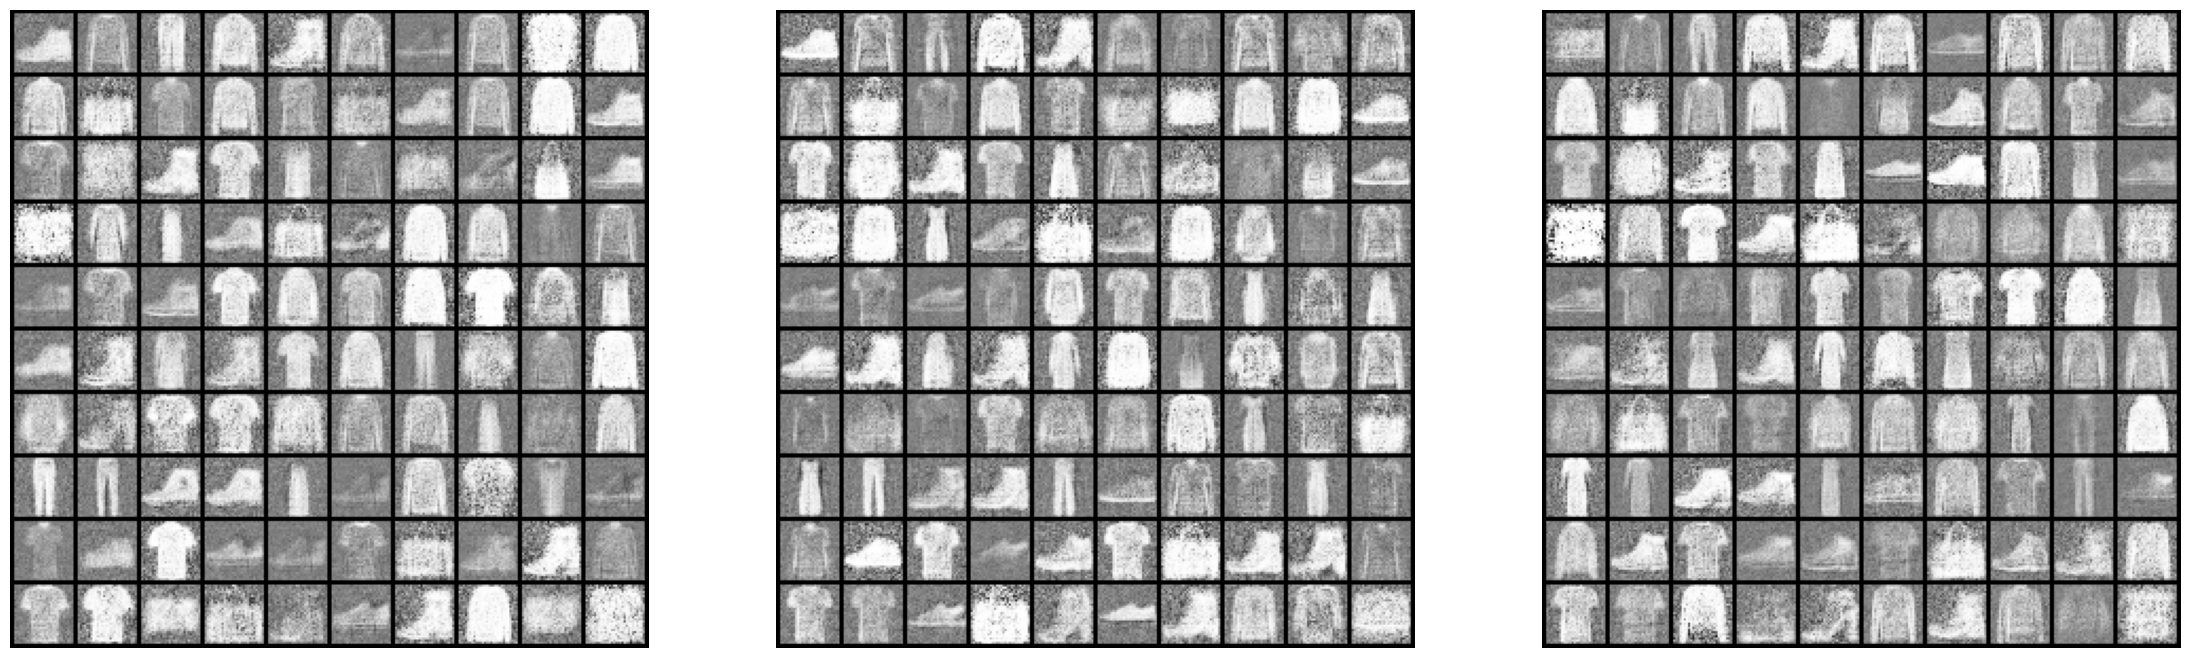

In [ ]:
import matplotlib.image as mpimg

# List of image paths
image_paths = [
    './sample_data/transf_fake_images-0010.png',
    './sample_data/transf_fake_images-0050.png',
    './sample_data/transf_fake_images-0100.png'
]

# Plot images side by side
plt.figure(figsize=(28, 28))
for i, path in enumerate(image_paths):
    plt.subplot(1, len(image_paths), i + 1)
    img = mpimg.imread(path)
    plt.imshow(img)
    plt.axis('off')
plt.show()

#### Evaluate Performance of tranfer learned model

In [ ]:
def evaluate_discriminator(discriminator, test_loader):
    discriminator.eval()  # Set the model to evaluation mode
    correct_real = 0
    correct_fake = 0
    total = 0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.reshape(-1, image_size).to(device)
            outputs = discriminator(images)
            predicted_labels = (outputs >= 0.5).float()  # Threshold at 0.5 for binary classification

            # Compute accuracy for real and fake images separately
            correct_real += (predicted_labels[:len(images)//2] == 1).sum().item()  # Assuming first half are real images
            correct_fake += (predicted_labels[len(images)//2:] == 0).sum().item()  # Assuming second half are fake images
            total += len(images)

    accuracy_real = 100 * correct_real / (total // 2)
    accuracy_fake = 100 * correct_fake / (total // 2)
    accuracy_total = 100 * (correct_real + correct_fake) / total

    print('Accuracy on real images: {:.2f}%'.format(accuracy_real))
    print('Accuracy on fake images: {:.2f}%'.format(accuracy_fake))
    print('Overall accuracy: {:.2f}%'.format(accuracy_total))

    return accuracy_real, accuracy_fake, accuracy_total

# Usage
trans_real, trans_fake, trans_overall = evaluate_discriminator(D, test_loader)

Accuracy on real images: 64.46%
Accuracy on fake images: 34.44%
Overall accuracy: 49.45%


### Step 7. Save w/o checkpoints

In [ ]:
torch.save(G.state_dict(), 'generator_weights_wo_checkpoints.pth')
torch.save(D.state_dict(), 'discriminator_weights_wo_checkpoints.pth')

### Step 8. Load w/o checkpoints

In [ ]:
# Load checkpoint models for generator and discriminator
generator_checkpoint_path     = 'generator_weights_wo_checkpoints.pth'
discriminator_checkpoint_path = 'discriminator_weights_wo_checkpoints.pth'

# Load weights into the models
G.load_state_dict(torch.load(generator_checkpoint_path))
D.load_state_dict(torch.load(discriminator_checkpoint_path))

<All keys matched successfully>

In [ ]:
G

Sequential(
  (0): Linear(in_features=100, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=512, bias=True)
  (5): ReLU()
  (6): Linear(in_features=512, out_features=784, bias=True)
  (7): Tanh()
)

In [ ]:
D

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

# Part 2 -  LSGAN

Repeat the steps 1-6 with Least Square GAN and compare it with GAN results

#### Reinitialize the model

In [ ]:
G.to(device);
D.to(device);

In [ ]:
# For LSGAN
criterion = nn.MSELoss()

Saving fake_LSGAN_images-0000.png


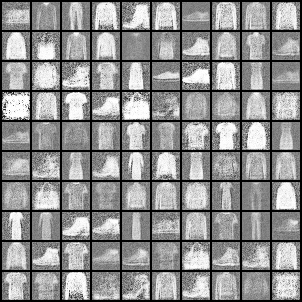

In [ ]:
def save_fake_LSGAN_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_LSGAN_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_LSGAN_images(0)
Image(os.path.join(sample_dir, 'fake_LSGAN_images-0000.png'))

In [ ]:
%%time

num_epochs = 300
total_step = len(train_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = D_train(images) # discriminator ingests real and fake images
        g_loss, fake_images = G_train()                  # generator creates images

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_LSGAN_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.3514, g_loss: 0.4517, D(x): 0.61, D(G(z)): 0.35
Epoch [0/300], Step [400/600], d_loss: 0.4438, g_loss: 0.3266, D(x): 0.56, D(G(z)): 0.43
Epoch [0/300], Step [600/600], d_loss: 0.3922, g_loss: 0.3683, D(x): 0.58, D(G(z)): 0.40
Saving fake_LSGAN_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.3769, g_loss: 0.3749, D(x): 0.61, D(G(z)): 0.40
Epoch [1/300], Step [400/600], d_loss: 0.4364, g_loss: 0.3979, D(x): 0.55, D(G(z)): 0.41
Epoch [1/300], Step [600/600], d_loss: 0.4316, g_loss: 0.3719, D(x): 0.57, D(G(z)): 0.41
Saving fake_LSGAN_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.3986, g_loss: 0.4117, D(x): 0.58, D(G(z)): 0.40
Epoch [2/300], Step [400/600], d_loss: 0.4274, g_loss: 0.3763, D(x): 0.56, D(G(z)): 0.42
Epoch [2/300], Step [600/600], d_loss: 0.4268, g_loss: 0.4108, D(x): 0.58, D(G(z)): 0.40
Saving fake_LSGAN_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.4585, g_loss: 0.3966, D(x): 0.57, D(G(z)): 0.43
Epoch [3

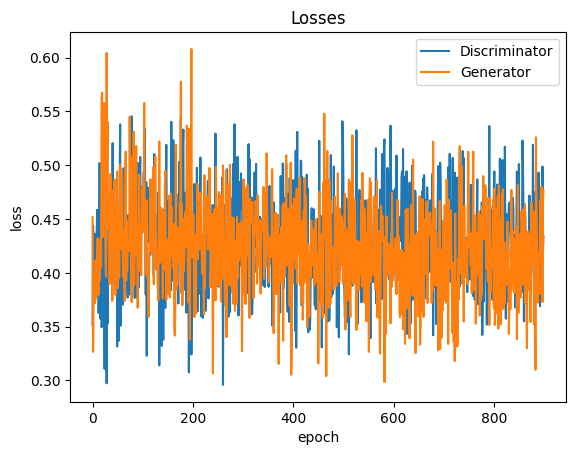

In [ ]:
import matplotlib.pyplot as plt

plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

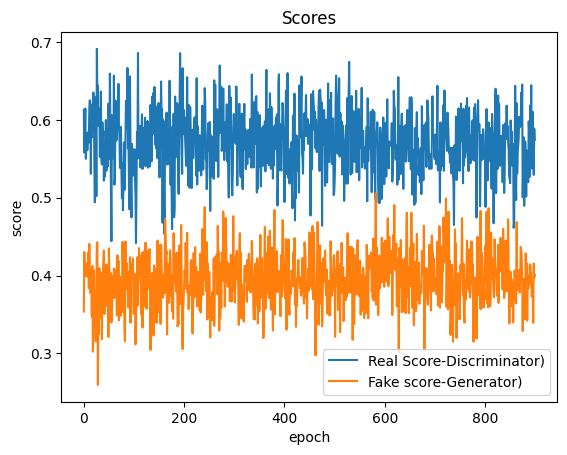

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score-Discriminator)', 'Fake score-Generator)'])
plt.title('Scores');

#### Evaluate Performance of LSGAN model (300 epochs)

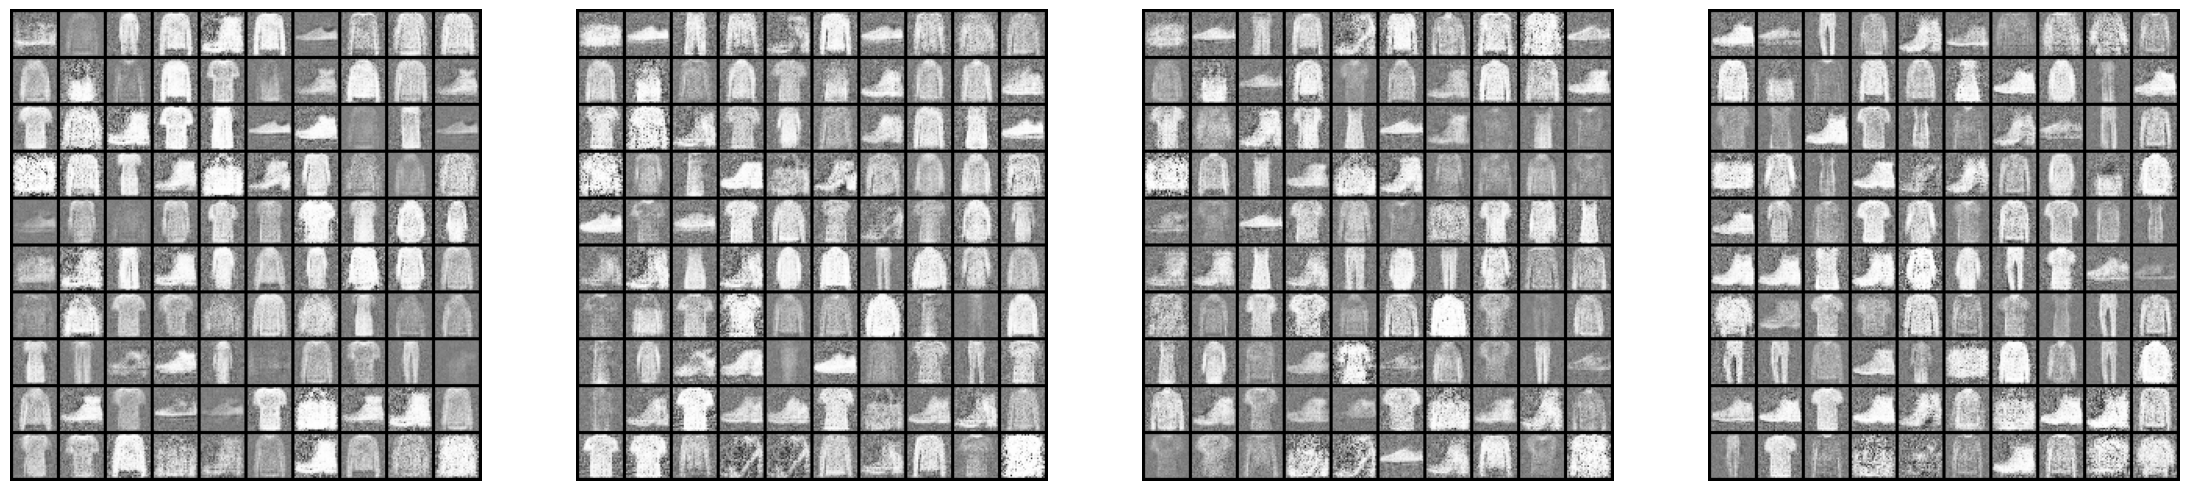

In [ ]:
import matplotlib.image as mpimg

# List of image paths
image_paths = [
    './sample_data/fake_LSGAN_images-0010.png',
    './sample_data/fake_LSGAN_images-0050.png',
    './sample_data/fake_LSGAN_images-0100.png',
    './sample_data/fake_LSGAN_images-0300.png'
]

# Plot images side by side
plt.figure(figsize=(28, 28))
for i, path in enumerate(image_paths):
    plt.subplot(1, len(image_paths), i + 1)
    img = mpimg.imread(path)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
def evaluate_discriminator(discriminator, test_loader):
    discriminator.eval()  # Set the model to evaluation mode
    correct_real = 0
    correct_fake = 0
    total = 0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.reshape(-1, image_size).to(device)
            outputs = discriminator(images)
            predicted_labels = (outputs >= 0.5).float()  # Threshold at 0.5 for binary classification

            # Compute accuracy for real and fake images separately
            correct_real += (predicted_labels[:len(images)//2] == 1).sum().item()  # Assuming first half are real images
            correct_fake += (predicted_labels[len(images)//2:] == 0).sum().item()  # Assuming second half are fake images
            total += len(images)

    accuracy_real = 100 * correct_real / (total // 2)
    accuracy_fake = 100 * correct_fake / (total // 2)
    accuracy_total = 100 * (correct_real + correct_fake) / total

    print('Accuracy on real images: {:.2f}%'.format(accuracy_real))
    print('Accuracy on fake images: {:.2f}%'.format(accuracy_fake))
    print('Overall accuracy: {:.2f}%'.format(accuracy_total))

    return accuracy_real, accuracy_fake, accuracy_total

# Usage
LSGAN_real, LSGAN_fake, LSGAN_overall = evaluate_discriminator(D, test_loader)

Accuracy on real images: 60.08%
Accuracy on fake images: 40.54%
Overall accuracy: 50.31%


In [ ]:
print('Accuracy of Models')
print(f'GAN:        Real {GAN_real} | Fake {GAN_fake} | Overall {GAN_overall}')
print(f'Transf GAN: Real {trans_real} | Fake {trans_fake} | Overall {trans_overall}')
print(f'LSGN:       Real {LSGAN_real} | Fake {LSGAN_fake}  | Overall {LSGAN_overall}')

Accuracy of Models
GAN:        Real 59.74 | Fake 40.8 | Overall 50.27
Transf GAN: Real 64.46 | Fake 34.44 | Overall 49.45
LSGN:       Real 60.08 | Fake 40.54  | Overall 50.31


The first GAN run of the model experienced the most significant gains improving generator loss from about 6 to 2.

Saving with checkpoints, loading, and retraining with 100 epochs further improved but marginally, stabalizing around 2 generator loss and 1 discriminator loss.  

Reinitializing and runinng the LSGAN model with 300 epochs stabalized around 0.5 generator loss and 0.35 discriminator loss.

Neither the discriminator, nor generator dominated but convergence was not clear either indicating mode collapse or the likelihood that the model produced a small variety of imates with many duplicates because the generator does not learn a depth of feature representation incorrectly applying similar outputs to a variety of different inputs. To ammend this I experimented with changing the input dimension of 64 to 100 improve the generators ability to create enough randomdess to differentiate the images and it is likely the are too similar. Further, to improve the outputs of the generator, an additional filter is added to generate a wider variety of features.

Results after experiments for the second run of a clean GAN resulted in a generator loss from about 4.5 to 1 with a generator score from 0.3 to 0.4. Discrimnator loss was about 0.9 to 1.1 with a score of 0.9 to 0.6.

Saving with checkpoints of the experiment GAN, loading, and retraining with 100 epochs resulted in a generator loss from about 1.15 to 1.1 with a generator score from 0.37 to 0.38. Discrimnator loss was about 1.2 to 1.1 with a score of 0.6 to 0.58, indicating confergence.  

Reinitializing and runinng the LSGAN model with 300 epochs stabalized around 0.45 generator loss and 0.43 discriminator loss. Generator scores ranged from 0.59 to 0.56 and discriminator scores 0.36 to 0.38.